**Імпорт бібліотек**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp

**Рівень значущості для статистичних критеріїв**

In [7]:
ALPHA = 0.05

**Перевірка нормальності розподілу за критерієм Пірсона** 

*Розраховує теоретичні ймовірності, порівнює їх із емпіричними частотами та обчислює χ2*

*Повертає таблиці і результат перевірки гіпотези*

In [8]:
def normality_check_pearson(data):
    borders = data["borders"]
    frequencies = data["frequencies"]
    dist_len = sum(frequencies)
    mean = calc_mean(data)
    std_dev = calc_std_dev(data)
    prob_table = []
    chi2_table = []
    total_theor_prob = 0
    total_chi2 = 0

    for idx in range(len(frequencies)):
        left = float("-inf") if idx == 0 else borders[idx]
        right = float("inf") if idx == len(frequencies) - 1 else borders[idx + 1]

        z_l = (left - mean) / std_dev
        z_r = (right - mean) / std_dev
        phi_l = laplace(z_l)
        phi_r = laplace(z_r)
        prob = phi_r - phi_l
        prob_table.append([left, right, z_l, z_r, phi_l, phi_r, prob])
        total_theor_prob += prob

    prob_table.append(["", "", "", "", "", "", total_theor_prob])

    for idx, freq in enumerate(frequencies):
        theor_freq = dist_len * prob_table[idx][6]
        diff = freq - theor_freq
        chi2_contrib = (diff ** 2) / theor_freq
        total_chi2 += chi2_contrib

        chi2_table.append([freq, theor_freq, diff, diff ** 2, chi2_contrib])

    chi2_table.append([dist_len, "", "", "", total_chi2])
    crit = chi2_crit(ALPHA, len(frequencies) - 1 - 2)

    return {
    "prob_table": prob_table,
    "chi2_table": chi2_table,
    "chi2_emp": total_chi2,
    "chi2_crit": crit,
    "is_normal": total_chi2 < crit
    }

**Перевірка нормальності розподілу за критерієм Колмогорова**

*Розраховує емпіричну та теоретичну функції розподілу, порівнює їх відхилення*

*Повертає таблицю і значення λ, D та критичні значення*

In [9]:
def normality_check_kolmogorov(data):
    borders = data["borders"]
    freqs = data["frequencies"]
    total = sum(freqs)
    mean = calc_mean(data)
    std = calc_std_dev(data)

    extended = {
        "borders": [float("-inf")] + borders + [float("inf")],
        "frequencies": [0] + freqs + [0]
    }

    borders = extended["borders"]
    freqs = extended["frequencies"]
    count_table = []
    accum_freq = 0
    max_diff = 0

    for i in range(1, len(freqs)):
        accum_freq += freqs[i] / total
        z = (borders[i + 1] - mean) / std
        theor = sp.norm.cdf(z)
        diff = abs(theor - accum_freq)
        max_diff = max(max_diff, diff)

        count_table.append([
            borders[i], borders[i + 1], freqs[i], accum_freq,
            z, theor, diff
        ])

    lam_emp = max_diff * (total ** 0.5)
    return {
    "kolm_table": count_table,
    "max_diff": max_diff,
    "lambda_emp": lam_emp,
    "lambda_crit": lambda_crit(ALPHA),
    "kolmog_crit": kolmogorov_crit(ALPHA, total),
    "beta_crit": prob_from_lambda(lam_emp)
    }

**Розрахунок математичного сподівання за формулою для інтервального ряду**

In [10]:
def calc_mean(data):
    borders = data["borders"]
    freqs = data["frequencies"]
    total = sum(freqs)
    return sum((borders[i] + borders[i+1]) / 2 * freqs[i] for i in range(len(freqs))) / total

**Розрахунок середньоквадратичного відхилення за формулою для інтервального ряду**

In [11]:
def calc_std_dev(data):
    mean = calc_mean(data)
    borders = data["borders"]
    freqs = data["frequencies"]
    total = sum(freqs)
    variance = sum(((borders[i] + borders[i+1]) / 2 - mean) ** 2 * freqs[i] for i in range(len(freqs)))
    return (variance / (total - 1 if total <= 30 else total)) ** 0.5

**Обчислення значення функції Лапласа (центрованої) через стандартну нормальну функцію розподілу**

In [12]:
def laplace(x):
    return sp.norm.cdf(x) - 0.5

**Критичне значення χ2 для заданого рівня значущості та ступенів свободи**

In [13]:
def chi2_crit(alpha, k):
    return sp.chi2.ppf(1 - alpha, k)

**Критичне значення λ для Колмогорова**

In [14]:
def lambda_crit(alpha):
    return sp.kstwobign.ppf(1 - alpha)

**Критичне значення для Колмогорова, точне**

In [15]:
def kolmogorov_crit(alpha, n):
    return sp.kstwo.ppf(1 - alpha, n)

**Ймовірність отримати значення > λ (p-value)**

In [16]:
def prob_from_lambda(l):
    return 1 - sp.kstwobign.cdf(l)

**Форматування числових значень**

In [17]:
def format_val(v):
    return round(v, 6) if v != "" else ""

**Виведення всіх таблиць та результатів критеріїв**

In [18]:
def display_results(data):
    res_pearson = normality_check_pearson(data)
    res_kolm = normality_check_kolmogorov(data)

    print("\n-- КРИТЕРІЙ ПІРСОНА --")
    df1 = pd.DataFrame([
        ["Σ" if i == len(res_pearson["prob_table"]) - 1 else i + 1] + [format_val(v) for v in row]
        for i, row in enumerate(res_pearson["prob_table"])
    ], columns=["#", "Xi", "Xi+1", "Zi", "Zi+1", "Φ(Zi)", "Φ(Zi+1)", "P"])
    print(df1.to_string(index=False))
    print("Сума = 1, отже розподіл правильний")

    df2 = pd.DataFrame([
        ["Σ" if i == len(res_pearson["chi2_table"]) - 1 else i + 1] + [format_val(v) for v in row]
        for i, row in enumerate(res_pearson["chi2_table"])
    ], columns=["#", "ni", "n`i", "Δ", "Δ^2", "Δ^2/n`i"])
    print(df2.to_string(index=False))

    print(f"\nX2_сп = {res_pearson['chi2_emp']:.5f}, X2_кр = {res_pearson['chi2_crit']:.5f} → Гіпотеза про нормальний розподіл {'приймається'
    if res_pearson['is_normal'] else 'відхиляється'}")

    print("\n-- КРИТЕРІЙ КОЛМОГОРОВА --")
    df3 = pd.DataFrame([
        [i + 1] + [format_val(v) for v in row]
        for i, row in enumerate(res_kolm["kolm_table"])
    ], columns=["#", "Xi", "Xi+1", "ni", "F*", "(X - μ)/σ", "F(x)", "|F* - F(x)|"])
    print(df3.to_string(index=False))

    print( f"\nλ_сп = {res_kolm['lambda_emp']:.5f}, λ_кр = {res_kolm['lambda_crit']:.5f}, D* = {res_kolm['max_diff']:.5f}, K_кр = {res_kolm['kolmog_crit']:.5f}, β_кр = {res_kolm['beta_crit']:.5f}")
    print(f"→ Гіпотеза {'приймається' if res_kolm['lambda_emp'] < res_kolm['lambda_crit'] else 'відхиляється'} за λ")
    print(f"→ Гіпотеза {'приймається' if res_kolm['max_diff'] < res_kolm['kolmog_crit'] else 'відхиляється'} за D")
    print(f"→ Гіпотеза {'приймається' if res_kolm['beta_crit'] > 0.05 else 'відхиляється'} за β")

    show_hist(data)

**Візуалізація гістограми частот**

In [19]:
def show_hist(data):
    borders = data["borders"]
    freqs = data["frequencies"]
    heights = [freq / (borders[i+1] - borders[i]) for i, freq in enumerate(freqs)]
    centers = [(borders[i] + borders[i+1]) / 2 for i in range(len(freqs))]

    plt.figure(figsize=(10, 6))
    plt.title("Гістограма інтервального ряду")
    plt.xlabel("X")
    plt.ylabel("Щільність")

    for i in range(len(freqs)):
        plt.bar(
            x=centers[i],
            height=heights[i],
            width=(borders[i + 1] - borders[i]),
            align='center', edgecolor='black', color='skyblue'
        )

    # Додаткова лінія через центри інтервалів
    plt.plot(centers, heights, marker='o', linestyle='-', color='red', label='Полігон частот')
    plt.legend()
    plt.tight_layout()
    plt.show()

**Ініціалізація даних**

In [20]:
intStatDist = {
    "borders": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "frequencies": [10, 8, 7, 10, 22, 18, 14, 11],
}

**Вивід результатів**


-- КРИТЕРІЙ ПІРСОНА --
#   Xi Xi+1        Zi      Zi+1     Φ(Zi)   Φ(Zi+1)        P
1 -inf    2      -inf -1.621623      -0.5 -0.447558 0.052442
2    2    3 -1.621623 -1.146074 -0.447558 -0.374118 0.073440
3    3    4 -1.146074 -0.670525 -0.374118 -0.248738 0.125379
4    4    5 -0.670525 -0.194975 -0.248738 -0.077294 0.171444
5    5    6 -0.194975  0.280574 -0.077294  0.110481 0.187775
6    6    7  0.280574  0.756123  0.110481  0.275212 0.164731
7    7    8  0.756123  1.231673  0.275212  0.390964 0.115752
8    8  inf  1.231673       inf  0.390964       0.5 0.109036
Σ                                                   1.000000
Сума = 1, отже розподіл правильний
#  ni        n`i         Δ        Δ^2   Δ^2/n`i
1  10   5.244204  4.755796  22.617598  4.312876
2   8   7.344027  0.655973     0.4303  0.058592
3   7  12.537944 -5.537944   30.66882  2.446081
4  10  17.144443 -7.144443  51.043068  2.977237
5  22  18.777527  3.222473  10.384329  0.553019
6  18  16.473093  1.526907   2.331444  0.14

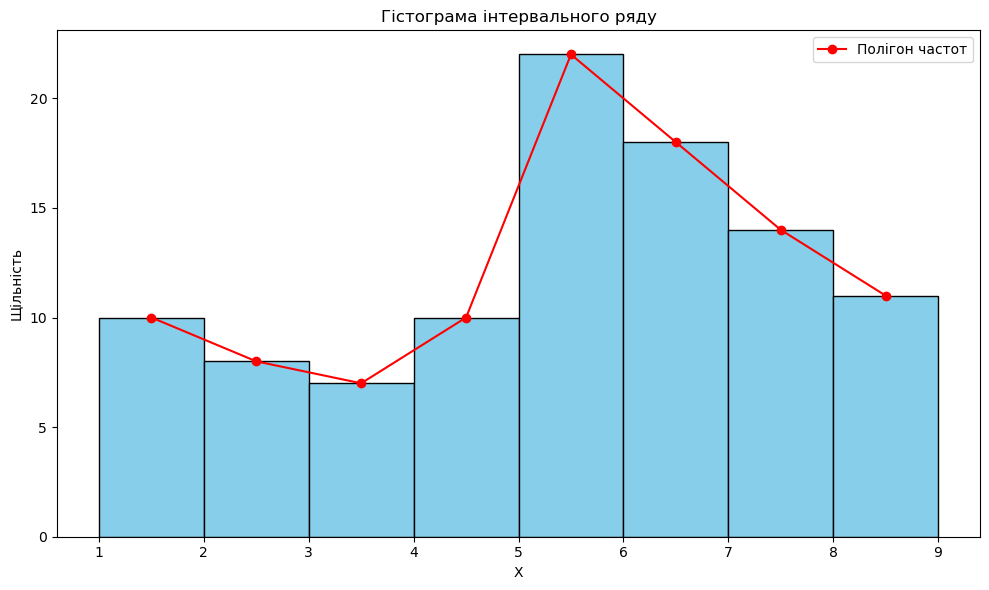

In [21]:
display_results(intStatDist)